# Kaggle Points Team Size Effect

[The forum topic and debate that sparked this idea is here][3].
This Notebook is to show: what would Kaggle competition rankings look like with points spread evenly between team-mates?

The official [Kaggle competition rankings are here][2].
The competition rankings points formula is [here on the progression page][1].

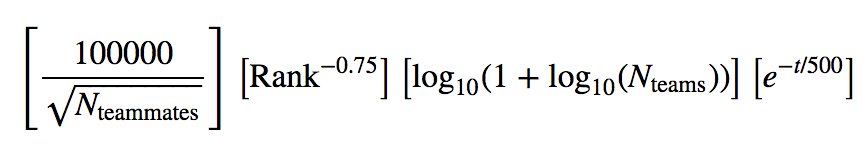

The points each member of a team receives are divided by the square root of the team size. So a team of 4 gets half of the teams points each, a team of 9 gets a third each. This inflates the points teams earn.

The square root used can be generalised as a team size exponent, i.e. square root is like raising to a half. So the team size exponent 0.5 is currently used.

An exponent of 1 would spread points evenly - so each member of a team of 5 gets a fifth of the points. Sounds fair. This is the formula originally used up to 2015.

Higher numbers could be used, as CPMP [suggested here - a value of 2 would penalise teaming!][3]

## Contents

 * [Data Prep](#Data-Prep)
 * [Plot Points Distributions](#Plot-Points-Distributions)
 * [Actual Top 100](#Actual-Top-100)
 * [Count Medals & "Whiffs"](#Count-Medals-&-"Whiffs")
 * [Square Root: Exponent 0.5](#Square-Root:-Exponent-0.5)
 * [Even Stevens: Exponent 1](#Even-Stevens:-Exponent-1)
 * [Penalise Teamwork! Exponent 2](#Penalise-Teamwork!-Exponent-2)
 * [Compromise: Exponent 0.75](#Compromise:-Exponent-0.75)
 * [Plot Users with Alternative Team Exponents](#Plot-Users-with-Alternative-Team-Exponents)
 * [Conclusions](#Conclusions)

 [1]: https://www.kaggle.com/progression
 [2]: https://www.kaggle.com/rankings
 [3]: https://www.kaggle.com/c/home-credit-default-risk/discussion/64045
 

In [1]:
# Fork and change this - save a breakdown of points per competition for each user in this list
KAGGLERS = ['jtrotman']

# Data Prep

In [2]:
%matplotlib inline
import numpy as np, pandas as pd
import matplotlib.pylab as plt
import plotly.express as px
from jt_mk_utils import *

DISPLAY_ROWS = 100
BAR_COLOR = '#5fd65f'
pd.options.display.max_rows = DISPLAY_ROWS

def user_name_link(r):
    return f'<a href="https://www.kaggle.com/{r.UserName}">{r.DisplayName}</a>'

def comp_link(r):
    return f'<a href="https://www.kaggle.com/c/{r.Slug}" name="{r.Subtitle}">{r.Title}</a>'

def users_show(df, add_rank='TruePoints'):
    # adjustments for display
    df = df.head(DISPLAY_ROWS).copy()
    uid = df.apply(user_name_link, axis=1)
    df.pop('UserName')
    df.pop('DisplayName')
    df.insert(0, 'DisplayName', uid)
    df.insert(0, 'Rank', df[add_rank].rank(ascending=False, method='first').astype(int))
    df = df.set_index('Rank')
    # put newlines in column names for better display in Kaggle UI
    df.columns = df.columns.str.replace('([a-z])([A-Z])', r'\1\n\2')
    bar = [c for c in ['Points', 'True\nPoints'] if c in df.columns]
    return df.style.bar(subset=bar, vmin=0, color=BAR_COLOR)

In [3]:
competitions = read_competitions().set_index('Id')
competitions.shape

In [4]:
teams = read_teams().set_index('Id')
teams.shape

In [5]:
members = read_team_memberships().set_index('Id')
members.shape

In [6]:
users = read_users(filter=("Id", members.UserId)).set_index('Id')
users.shape

In [7]:
ach = read_user_achievements(filter=("UserId", members.UserId)).set_index('UserId')
d = ach.loc[ach.AchievementType=="Competitions"].Points
users['TruePoints'] = users.index.map(d).fillna(0).astype(int)
users['TrueRank'] = users['TruePoints'].rank(ascending=False, method='first').astype(int)

Most recent competitions in [Meta Kaggle][1]:

[1]: https://www.kaggle.com/kaggle/meta-kaggle

In [8]:
cshow = [
    'Competition',
    'Subtitle',
    'DeadlineDate',
    'TotalTeams',
]
tmp = competitions.query('HostSegmentTitle!="InClass"').sort_values('DeadlineDate', ascending=False)
tmp.assign(Competition=tmp.apply(comp_link, 1))[cshow].head().style

In [9]:
users.TruePoints.value_counts().head()

In [10]:
plt.rc('figure', figsize=(14, 7))
plt.rc('font', size=14)
plt.rc('axes', xmargin=0.04)

# Plot Points Distributions

In [11]:
users.TruePoints.plot.hist(bins=100,
                           log=True,
                           grid=True,
                           title='Log Count of Users with Points');

In [12]:
users.TruePoints.sort_values(ascending=False).head(500).reset_index(drop=True).plot(title="Ranking Points of top 500")
plt.grid();

In [13]:
users.TruePoints.sort_values(ascending=False).head(30).reset_index(drop=True).plot(title="Ranking Points of top 30")
plt.grid();

# Actual Top 100

Quick preview of top 100 in points.
Check against [official list here][1].
The points (from UserAchievements.csv) match perfectly.
The ranks differ slightly: Users are not ranked until they have 3+ silver results - just sorting by points alone ignores that rule, so some extra users with 1-2 stellar finishes may appear here.

### Note: also this [long standing bug](https://www.kaggle.com/kaggle/meta-kaggle/discussion/181048) that new users are not appearing in UserAchievements.csv

[1]: https://www.kaggle.com/rankings

In [14]:
users_show(users.sort_values('TruePoints', ascending=False).head(DISPLAY_ROWS))

Adjusted from:

https://github.com/Far0n/kaggletils/blob/master/kaggletils/kaggle/ranking.py

In [15]:
def kaggle_points(rank=1, nteams=1, team_size=1, t=0.0, mult=1, teams_exp=0.5):
    return ((100000. / (team_size**teams_exp))  # team size factor
            * (rank**-0.75)                     # leaderboard position
            * (np.log10(1 + np.log10(nteams)))  # size of competition
            * (np.exp(-t / 500.))               # time decay (days since deadline)
            * (mult)                            # some comps are half points
            )

Formula depends on knowing # of teams - remove mostly *InClass* competitions that oddly have 0 teams.

In [16]:
competitions = competitions.query('TotalTeams>0').copy()
competitions.shape

In [17]:
from_comps = ['TotalTeams', 'DeadlineDate', 'UserRankMultiplier']

teams = teams.merge(competitions[from_comps], left_on='CompetitionId', right_index=True)
teams = teams.dropna(subset=['TotalTeams'])

In [18]:
# number of people in a team
teamSize = members.TeamId.value_counts()
teams['TeamSize'] = teams.index.map(teamSize)

Xmas optimisation challenges have PublicLeaderboardRank but no Private...

In [19]:
teams['FinalRank'] = teams['PrivateLeaderboardRank']
idx = teams.FinalRank.isnull()
teams.loc[idx, 'FinalRank'] = teams.loc[idx, 'PublicLeaderboardRank']
# No rank means entered but no submissions = no points
teams = teams.dropna(subset=['FinalRank'])

Points are computed only when a competition ends, and points from old results decay over time - use the date of the most recent competition as the reference date for this part.

In [20]:
ref_date = teams.DeadlineDate.max()
TSTAMP = ref_date.strftime('%y%m%d') # Timestamp for filenames
teams['DaysSince'] = (ref_date - teams.DeadlineDate).dt.days

# Count Medals & "Whiffs"

What do you call a non-medal winning competition result? A short word for "swing and a miss"? A [Whiff][1] :D

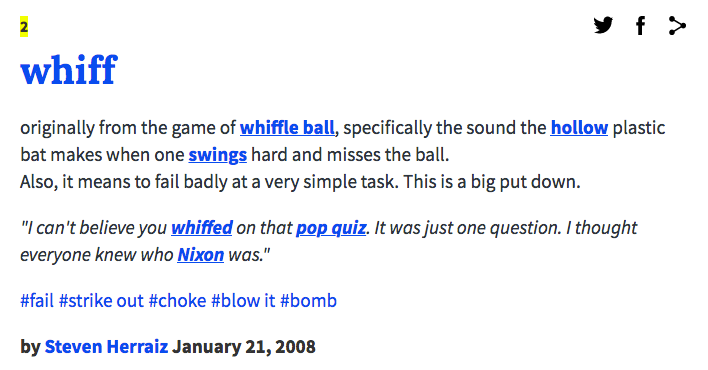

[1]: https://www.urbandictionary.com/define.php?term=whiff


In [21]:
MISS = 'Whiff'

Add fields to team memberships table for convenience.

In [22]:
from_users = ['DisplayName', 'UserName', 'PerformanceTier']
members = members.merge(users[from_users], left_on='UserId', right_index=True)

In [23]:
membersTeamSize = members.TeamId.map(teamSize)
membersMedal = members.TeamId.map(teams.Medal)
members['Comps'] = 1  # sum this to count comps
members['Solo'] = (membersTeamSize==1).astype(int)
members['SoloGold'] = ((membersMedal==1) & (membersTeamSize==1)).astype(int)
members['Gold'] = (membersMedal==1).astype(int)
members['Silver'] = (membersMedal==2).astype(int)
members['Bronze'] = (membersMedal==3).astype(int)
members[MISS] = (membersMedal.isnull()).astype(int)

Functions to summarize and show the users table.

In [24]:
def render(team_exponent):
    teams['Points'] = kaggle_points(teams.FinalRank,
                                    teams.TotalTeams,
                                    teams.TeamSize,
                                    teams.DaysSince,
                                    teams.UserRankMultiplier,
                                    team_exponent)
    
    # each member gets points as computed for team
    members['Points'] = members.TeamId.map(teams.Points)
    
    aggs = {
        'Comps': 'sum',
        'Solo': 'mean',
        'SoloGold': 'sum',
        'Gold': 'sum',
        'Silver': 'sum',
        'Bronze': 'sum',
        MISS: 'sum',
        'Points': 'sum'
    }
    df = members.groupby('UserName').agg(aggs)
    df = df.sort_values('Points', ascending=False).reset_index()
    # round down points now that they're all summed
    df['Points'] = np.floor(df.Points).astype(int)
    df['Solo'] = np.round(df.Solo, 2)
    # add in user fields
    df = df.join(users.set_index('UserName'), on='UserName', how='left')
    return df

# Summarize points earned in each competition for a user
def summarize_user(user, fname):
    df = members.query(f'UserName=="{user}"')
    df = df.sort_values('Points', ascending=False)
    df = df.join(teams.drop(['Points'], 1), on='TeamId')
    cshow = ['CompetitionId', 'DeadlineDate', 'Title', 'FinalRank', 'TeamSize', 'TeamName', 'Points']
    df = df.join(competitions.drop(from_comps, 1), on='CompetitionId')
    df = df[cshow].dropna()
    df.to_csv(fname, float_format='%.0f')

def summarize_users(team_exponent):
    for user in KAGGLERS:
        fname = f'{user}_points_{TSTAMP}_team_exp_{team_exponent}.csv'
        summarize_user(user, fname)

def show(team_exponent):
    df = render(team_exponent)  # Computes Points
    fname = f'comp_ranks_{TSTAMP}_team_exp_{team_exponent}.csv'
    df.query('Points>0').to_csv(fname, index_label='Index')
    summarize_users(team_exponent)  # Uses computed Points
    return users_show(df, add_rank='Points')

# Square Root: Exponent 0.5

The square root currently used, "Points" and "True Points" should match fairly closely.

### Discrepancies:

It has taken some time to iron out some bugs - this calculation now seems to roughly match the official points. There are still differences though.

Possible causes:

 - Special cases like masters-only competitions that are not in Meta Kaggle (very rare)
 - The exact date Kaggle used will have a small effect on how much old results are decayed.
 - Users are not ranked until they have 3+ silver results.

In [25]:
show(team_exponent=0.5)

# Even Stevens: Exponent 1

An even split between team mates.

With the bar chart display for the points columns you can easily see who has more "True Points" than they would under this hypothetical system, and who has risen higher here but has fewer "True Points".



In [26]:
show(team_exponent=1)

# Penalise Teamwork! Exponent 2

[CPMP suggested this here!][1]
Dividing by square of team size would actively punish teaming up.
There is potentially a ***lot*** of synergy in teaming up (pooling of ideas *and* hardware), so in some ways this makes sense.

People with a higher "Solo" proportion will of course be higher now, quite a lot of *soloists* jump into the top 100 with this system, even some from outside the top 200.

This is seriously unlikely to be adopted but let's see what it would be like :-)

 [1]: https://www.kaggle.com/c/home-credit-default-risk/discussion/64045#375129
 [2]: https://www.kaggle.com/c/avito-demand-prediction/discussion/59881

In [27]:
show(team_exponent=2)

# Compromise: Exponent 0.75

 - Team exponent of 2 seems way too harsh to me.
 - Team exponent of 1 seems too harsh to me.
 - Team exponent of 0.5 seems too generous to me.
 - The magic number -0.75 is already used in the rankings formula.

Let's try a team exponent of 0.75.

This is purely subjective - people who mostly compete solo would prefer 0.75 to 0.5, those who team-up would prefer 0.5 or even lower :-)

In devising a ranking formula could there be some deep seated mental bias where numbers like 0.5, 1 or 2 are preferred and 0.75 seems harder to justify?
Perhaps the square root symbol *looks* nicer?

In [28]:
show(team_exponent=0.75)

In [29]:
top = users.query("TrueRank<=100").copy()
top_memb = members[members.UserId.isin(top.index)].copy()
top_teams = teams[teams.index.isin(top_memb.TeamId)].copy()
top["SoloMean"] = top_memb.groupby("UserId").Solo.mean()

dfs = []
for team_exponent in np.arange(5, 21) / 10:
    top_teams['Points'] = kaggle_points(top_teams.FinalRank,
                                    top_teams.TotalTeams,
                                    top_teams.TeamSize,
                                    top_teams.DaysSince,
                                    top_teams.UserRankMultiplier,
                                    team_exponent)
    top_memb['Points'] = top_memb.TeamId.map(top_teams.Points)
    df = top.copy()
    df['TeamExponent'] = team_exponent
    df['Points'] = top_memb.groupby('UserId').Points.sum()
    df['Rank'] = df['Points'].rank(ascending=False, method='first')
    dfs.append(df)

df = pd.concat(dfs)
df["Tier"] = np.asarray(["", "", "Expert", "Master", "GM"])[df.PerformanceTier]
df.shape

# Plot Users with Alternative Team Exponents

In [30]:
fig = px.scatter(
    df,
    title="Top User Rankings With Alternative Team Exponent",
    x="Rank",
    y="Points",
    animation_frame="TeamExponent",
    size="TruePoints",
    symbol="Tier",
    color="Tier",
    hover_name="DisplayName",
    hover_data=["UserName", "TrueRank", "SoloMean"],
    size_max=20,
    range_y=[df["Points"].min() * 0.9,
             df["Points"].max() * 1.05])

fig.show()

# Conclusions

[See this forum thread for a big debate](https://www.kaggle.com/c/home-credit-default-risk/discussion/64045) on team sizes and gamification.

Do ***you*** think a team of 16 should each get a **quarter** of the "team points" instead of a **sixteenth**?


Of course, the ranking system is known, the formula freely available, and it will have influenced people's team-up decisions.
In that respect changing it now could seem unfair.

Does it matter? Does the current global ranking system motivate ***you*** to compete?

I personally am a bit put off by how much *quantity* is rewarded over *quality* - you could go quite far by just robo-submitting the top public solutions and blends of them.
A *few* competitions arise where thousands of ranking points are given out for just the sample submission or a simple public baseline, [positions 45 to 251 here for example](https://www.kaggle.com/c/landmark-retrieval-2020/leaderboard).
All have the same score but the *early-bird super-fast geezer-geese* get:

In [31]:
kaggle_points(rank=45, nteams=541, team_size=1)

The *straggler Kagglers* with **exactly the same score** get:

In [32]:
kaggle_points(rank=251, nteams=541, team_size=1)

Does not seem fair or sensible: part of the game here is just showing up early.

I [suggested here](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56182#325640) that massive groups of teams with the same score should be grouped into an implicit team to avoid this...
These long chains of "competitors" all submitting the same thing are a common enough feature of competitions to have been given a name!
[Carl McBride Ellis calls them *Isoscore strings*](https://www.kaggle.com/carlmcbrideellis/shakeup-scatterplots-boxes-strings-and-things) :)

It takes little effort to make a trivial improvement on the best public solution(s) to jump ahead of these blocks of clones, but some still don't go that far.
This is the *Farmville* side of Kaggling... rewarding constant involvement, even at the shallowest level.

(Same thing applies, IMHO, to some datasets, where people simply upload things *curated elsewhere* and are rewarded with a medal; making the datasets tier something of a *form-filler* achievement.
Similarly, there appears to be **no incentive** to keep a gold dataset updated, Kaggle becomes a *stale middleman*.)